In [ ]:
%%HTML
<!-- Mejorar visualización en proyector -->
<style>
.rendered_html {font-size: 1.2em; line-height: 150%;}
div.prompt {min-width: 0ex; padding: 0px;}
.container {width:95% !important;}
</style>

In [1]:
%matplotlib notebook
%autosave 60
import numpy as np
import matplotlib.pyplot as plt
import torch
import pyro
from tqdm import tqdm_notebook

Autosaving every 60 seconds


<IPython.core.display.Javascript object>


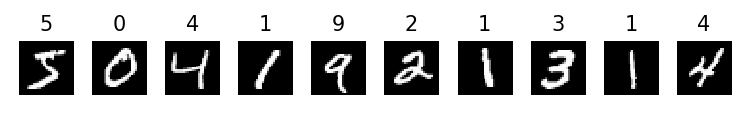

In [2]:
import torchvision
path_to_datasets = '/home/phuijse/datasets'
mnist_train_data = torchvision.datasets.MNIST(path_to_datasets, train=True, download=True,
                                              transform=torchvision.transforms.ToTensor())
mnist_test_data = torchvision.datasets.MNIST(path_to_datasets, train=False, download=True,
                                             transform=torchvision.transforms.ToTensor())

test_data = mnist_test_data.data.reshape(-1, 28*28).float()/255.
fig, ax = plt.subplots(1, 10, figsize=(6, 1), tight_layout=True)
for i in range(10):
    image, label = mnist_train_data[i]
    ax[i].imshow(image.numpy()[0, :, :], cmap=plt.cm.Greys_r)
    ax[i].axis('off')
    ax[i].set_title(label)

# Latent Variable Models (LVM)


Let's say we want to model a dataset $X = (x_1, x_2, \ldots, x_N)$ with $x_i \in \mathbb{R}^D$ 

> We are looking for $p(x)$

Each sample has D attributes

> These are the **observed variables** (visible space)

To model the data we have to propose dependency relationships between attributes

> Modeling correlation is difficult

One alternative is to assume that what we observe is correlated due to *hidden causes*

> These are the **latent variables** (hidden space)

Models with latent variables are called **Latent Variable Models** (LVM)

Then we get the marginal using

$$
\begin{align}
p(x) &= \int_z p(x, z) \,dz \nonumber \\
&= \int_z p(x|z) p(z) \,dz \nonumber
\end{align}
$$

Did we gain anything? 

> The integral can be hard to solve (in some cases it is tractable)

The answer is YES

> We can propose simple $p(x|z)$ and $p(z)$ and get complex $p(x)$

If the integral is intractable we try approximate inference

# Principal Component Analysis (PCA)

PCA is an algorithm to reduce the dimensionality of continous data

Let's say we have $X = (x_1, x_2, \ldots, x_N) \in \mathbb{R}^{N \times D}$ 

In classical PCA we 

1. Compute covariance matrix $C = \frac{1}{N} X^T X$
1. Solve the eigen value problem $(C - \lambda I)W = 0$

This comes from 

$$
\min_W W^T C W, \text{s.t.} ~ W^T W = I
$$

> PCA finds an **orthogonal transformation** $W$ that **minimizes the variance** of the projected data $XW$

Then we can reduce the amount of columns of $W$ to reduce the dimensionality of $XW$


### Example: Classical PCA for MNIST using pytorch

Implementation using Singular Value Decomposition (SVD)

In [ ]:
class PCA:
    def __init__(self, data, K=2):
        self.data_mean = torch.mean(data, dim=0)
        data_centered = data - self.data_mean.expand_as(data)
        U, S, V = torch.svd(data_centered.T)
        # S is sorted in decreasing order
        self.W = U[:, :K]
    
    def encode(self, x):
        return torch.mm(x - self.data_mean.expand_as(x), self.W)

    def decode(self, z):
        return self.data_mean + torch.mm(z, self.W.T)

Project data and plot the reduced space

In [ ]:
pca = PCA(test_data, K=2)
Z = pca.encode(test_data)

fig, ax = plt.subplots(figsize=(6, 4), tight_layout=True)
for digit in range(10):
    mask = mnist_test_data.targets == digit
    ax.scatter(Z[mask, 0].detach().numpy(), Z[mask, 1].detach().numpy(), 
               s=5, alpha=0.5, cmap=plt.cm.tab10, label=str(digit))
plt.legend()
ax.set_xlabel('PC 1'); ax.set_ylabel('PC 2');

The two most important principal components

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(4, 1.5), tight_layout=True)
for i in range(2):
    ax[i].imshow(pca.W[:, i].reshape(28, 28).detach().numpy())
    ax[i].axis('off')
    ax[i].set_title('PC %d' %(i))

Plot some reconstructions

In [ ]:
fig, ax = plt.subplots(2, 10, figsize=(8, 2), tight_layout=True)
reconstructions = pca.decode(Z[:10, :]).reshape(-1, 28, 28).detach().numpy()
for i in range(10):
    ax[0, i].imshow(test_data[i, :].reshape(28, 28).detach().numpy(), cmap=plt.cm.Greys_r)
    ax[0, i].axis('off')
    ax[1, i].imshow(reconstructions[i], cmap=plt.cm.Greys_r)
    ax[1, i].axis('off')

## Probabilistic interpretation for PCA

We can give a probabilistic interpretation to PCA as an LVM

An observed sample $x_i \in \mathbb{R}^D$ is modeled as 

$$
x_i = W z_i + B + \epsilon
$$

> The observed variable is related to the latent variable via a **linear mapping**

where 
- $B \in \mathbb{R}^D$ is the mean of $X$
- $W \in \mathbb{R}^{D\times K}$ is a linear transformation matrix
- $\epsilon$ is noise

> $z_i \in  \mathbb{R}^K$ is a continuous latent variable with $K<D$

#### Assumption: The noise is independent and Gaussian distributed with variance $\sigma^2$

Then

$$
p(x_i | z_i) = \mathcal{N}(B + W z_i, I \sigma^2)
$$

Note: In general factor analysis the noise has a diagonal covariance

#### Assumption: The latent variable has a standard Gaussian prior

$$
p(z_i) = \mathcal{N}(0, I)
$$


#### Marginal likelihood

The Gaussian is conjugated to itself (convolution of Gaussians is Gaussian)
$$
\begin{align}
p(x) &= \int p(x|z) p(z) \,dz \nonumber \\
&= \mathcal{N}(x|B, W^T W + I\sigma^2 ) \nonumber
\end{align}
$$

> We have parametrized a normal with full covariance from to normals with diagonal covariance"

The parameters are calculated from 
- $\mathbb{E}[x] = W\mathbb{E}[z] + \mu + \mathbb{E}[\epsilon]$
- $\mathbb{E}[(Wz + \epsilon)(Wz + \epsilon)^T] = W \mathbb{E}[zz^T] W^T + \mathbb{E}[\epsilon \epsilon^T]$

#### Posterior

Using Bayes we can obtain the posterior to go from observed to latent

$$
p(z|x) = \mathcal{N}(z|M^{-1}W^T(x-B), M\sigma^{-2} )
$$

where

$$
M = W^T W + I\sigma^2
$$

#### Training

We fit the model to find $W$, $\mu$ and $\sigma$ by maximizing the marginal likelihood

$$
\max \log L(W, B, \sigma^2) = \sum_{i=1}^N \log p(x_i)
$$

From here we can do derivatives and obtain closed form solutions of the parameters

> Solution for $W$ is equivalent to conventional PCA ($\sigma^2 \to 0$)

> Now we have estimated $\sigma$, we have error-bars for $z$ and the model is generative


## Self-study
- Barber, Chapter 21 and Murphy, Chapter 12
- Model with categorical latent variables: **Gaussian Mixture Model** (INFO337)


# VI for LVM

The LVM is defined by the joint density between observed $x$ and latent variables $z$

$$
p(x, z) = \prod_i p(x_i|z_i) p(z_i)
$$

If we follow the **PCA recipe** (Linear mapping, Gaussian likelihood and Gaussian prior) we obtained an analytical posterior

If we use a more complex (non-linear) mapping the posterior and evidence may not be tractable

> In such case, we can use **VI**

For a likelihood $p_\theta(x|z)$ and approximate posterior $q_\phi(z|x)$ we can write the ELBO

$$
\log p(x) = \sum_i \log p(x_i) \geq \mathcal{L}(\theta, \phi) = \sum_i \mathbb{E}_{z_i\sim q_\phi(z_i|x)} \left [\log p_\theta(x_i|z_i)\right ] + D_\text{KL}\left[q_\phi(z_i|x_i) || p(z_i) \right]
$$

If $q_\phi(z|x)$ is simple then the ELBO is tractable

> We maximize the ELBO to obtain $\phi$ and $\theta$ 

# Autoencoders

Autoencoders are deep neural networks for dimensionality reduction




#### Architecture
- Input and output dimensionality are equivalent
- Code (bottleneck) has smaller dimensionality than input/output
- **Encoder:** Neural net that maps input to code

$$
z = g_\phi(x)
$$

- **Decoder:** Neural net that maps code to output

$$
\hat x = f_\theta(z)
$$

- Model is trained by matching the input with the output (data as targets) with MSE (or cross-entropy)

$$
\hat \theta, \hat \phi = \text{arg} \min_{\phi, \theta} \| x - f_\theta(g_\phi(x)) \|^2
$$

> **Probabilistic intepretation:** Maximum likelihood with spherical Gaussian (or Bernoulli) likelihood

Typically an L2 regularizer on $\theta$ and $\phi$ is used

> **Probabilistic intepretation:** Spherical Gaussian prior




### Example: Autoencoder for MNIST in pytorch

One module for the encoder and one for the decoder

Two hidden layers each

In [ ]:
class Decoder(torch.nn.Module):
    def __init__(self, latent_dim, output_dim=28*28, hidden_dim=128):
        super(Decoder, self).__init__()
        self.hidden1 = torch.nn.Linear(latent_dim, hidden_dim)
        self.hidden2 = torch.nn.Linear(hidden_dim, hidden_dim)
        self.output = torch.nn.Linear(hidden_dim, output_dim)
        self.activation = torch.nn.Softplus()

    def forward(self, z):
        h = self.activation(self.hidden1(z))
        h = self.activation(self.hidden2(h))
        return self.output(h)

class Encoder(torch.nn.Module):
    def __init__(self, latent_dim, input_dim=28*28, hidden_dim=128):
        super(Encoder, self).__init__()
        self.hidden1 = torch.nn.Linear(input_dim, hidden_dim)
        self.hidden2 = torch.nn.Linear(hidden_dim, hidden_dim)
        self.code = torch.nn.Linear(hidden_dim, latent_dim)
        self.activation = torch.nn.Softplus()

    def forward(self, x):
        h = self.activation(self.hidden1(x))
        h = self.activation(self.hidden2(h))
        return self.code(h)
    
class AutoEncoder(torch.nn.Module):
    def __init__(self, latent_dim, hidden_dim=128):
        super(AutoEncoder, self).__init__() 
        self.encoder = Encoder(latent_dim, hidden_dim=hidden_dim)
        self.decoder = Decoder(latent_dim, hidden_dim=hidden_dim)
        
    def forward(self, x):
        return self.decoder(self.encoder(x))

Prepare datasets and dataloaders

In [ ]:
from torch.utils.data import DataLoader, SubsetRandomSampler

np.random.seed(0)
idx = list(range(len(mnist_train_data)))
np.random.shuffle(idx)
split = int(0.7*len(idx))

train_loader = DataLoader(mnist_train_data, batch_size=128, drop_last=True,
                          sampler=SubsetRandomSampler(idx[:split]))

valid_loader = DataLoader(mnist_train_data, batch_size=128, drop_last=True,
                          sampler=SubsetRandomSampler(idx[split:]))

Train the autoencoder

In [ ]:
model = AutoEncoder(latent_dim=2)
criterion = torch.nn.BCEWithLogitsLoss(reduction='sum')
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

fig, ax = plt.subplots()
for nepoch in range(10):
    # Plot latent space on the fly
    Z = model.encoder(test_data)
    ax.cla()
    for digit in range(10):
        mask = mnist_test_data.targets == digit
        ax.scatter(Z[mask, 0].detach().numpy(), Z[mask, 1].detach().numpy(), 
                   s=5, alpha=0.5, cmap=plt.cm.tab10, label=str(digit))
    plt.legend()
    fig.canvas.draw()
    # Actual training
    epoch_loss = 0.0
    for x, label in train_loader:
        optimizer.zero_grad()
        hatx = model.forward(x.reshape(-1, 28*28))
        loss = criterion(hatx, x.reshape(-1, 28*28))
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
    print("%d %f" %(nepoch, epoch_loss))

Inspect reconstructions

In [ ]:
output_activation = torch.nn.Sigmoid()
fig, ax = plt.subplots(2, 10, figsize=(8, 2), tight_layout=True)
reconstructions = output_activation(hatx).reshape(-1, 28, 28).detach().numpy()
for i in range(10):
    ax[0, i].imshow(x.detach().numpy()[i, 0, :, :], cmap=plt.cm.Greys_r)
    ax[0, i].axis('off')
    ax[1, i].imshow(reconstructions[i], cmap=plt.cm.Greys_r)
    ax[1, i].axis('off')

# Variational Autoencoder (VAE)



Proposed in 
In recent years there has been a revived interest into **marrying key ideas from Deep Learning and Approximate Bayesian Inference**

, after the works by [(Kingma and Welling, 2014)](https://arxiv.org/pdf/1312.6114.pdf) and [(Rezende *et al*, 2014)](https://arxiv.org/abs/1401.4082),

In the Variational Autoencoder (VAE)
- $p_\theta(x_i | z_i)$ and $q_\phi(z_i|x_i)$ are deep neural networks 
- We search for point estimates of the global parameters $\theta$ and $\phi$
- The bottleneck (code) is a random variable
- Assuming iid observations, each $x_i$ has a local latent variable $z_i$
- VI is used to estimate $z$


#### Assumption: The latent variable has a standard Gaussian prior

$$
p(z_i) = \mathcal{N}(0, I)
$$

#### Assumption: The approximate posterior is diagonal Gaussian

$$
q_\phi(z_i|x_i) = \mathcal{N}(\mu_i, I \sigma_i^2)
$$

> **Problem:** The number of variational parameters scales with $N$, infeasible for large datasets

The solution is **amortization**: Local variational parameters are replaced by a function

$$
\mu_i, \sigma_i = g_\phi(x_i)
$$

#### Assumption: The likelihood is chosen depending on the data

- Continous data: Diagonal Gaussian
$$
\mu_i, \sigma_i = f_\theta(z_i)
$$
- Binary data: Bernoulli
$$
p_i = f_\theta(z_i)
$$

## ELBO for the VAE

VAE is trained by maximizing the ELBO

$$
\mathcal{L}(\theta, \phi) = \sum_i \mathbb{E}_{z_i\sim q_\phi(z_i|x)} \left [\log p_\theta(x_i|z_i)\right ] + D_\text{KL}\left[q_\phi(z_i|x_i) || p(z_i) \right],
$$

via gradient descent

$$
\theta_{t+1} = \theta_{t} - \eta \nabla_\theta \mathcal{L}(\theta_{t}, \phi_{t})
$$

$$
\phi_{t+1} = \phi_{t} - \eta \nabla_\phi \mathcal{L}(\theta_{t}, \phi_{t})
$$


The derivative of the LHS term wrt to $\theta$ is

$$
\nabla_\theta \mathbb{E}_{z_i\sim q_\phi(z_i|x)}\left [\log p_\theta(x_i|z_i)\right ] = \mathbb{E}_{z_i\sim q_\phi(z_i|x)} \left [\frac{\nabla_\theta p_\theta(x_i|z_i)}{p_\theta(x_i|z_i)}\right ]
$$

which can be estimated via Monte-carlo sampling 

The derivative of the LHS term wrt to $\phi$ is 
$$
\nabla_\phi \mathbb{E}_{z_i\sim q_\phi(z_i|x)}\left [\log p_\theta(x_i|z_i)\right ]
$$

- https://pyro.ai/examples/svi_part_iii.html
- https://arxiv.org/pdf/1711.05597.pdf

In [ ]:
class Decoder(torch.nn.Module):
    def __init__(self, z_dim, hidden_dim):
        super(Decoder, self).__init__()
        self.hidden1 = torch.nn.Linear(z_dim, hidden_dim)
        self.hidden2 = torch.nn.Linear(hidden_dim, hidden_dim)
        self.output = torch.nn.Linear(hidden_dim, 784)
        self.activation = nn.Softplus()
        self.sigmoid = nn.Sigmoid()

    def forward(self, z):
        h = self.activation(self.hidden1(z))
        h = self.activation(self.hidden2(h))
        return self.sigmoid(self.output(h))

class Encoder(torch.nn.Module):
    def __init__(self, z_dim, hidden_dim):
        super(Encoder, self).__init__()
        self.hidden1 = nn.Linear(784, hidden_dim)
        self.hidden2 = nn.Linear(hidden_dim, hidden_dim)
        self.mu = torch.nn.Linear(hidden_dim, z_dim)
        self.logs = torch.nn.Linear(hidden_dim, z_dim)
        self.activation = nn.Softplus()

    def forward(self, x):
        x = x.reshape(-1, 784)
        h = self.activation(self.hidden1(x))
        h = self.activation(self.hidden2(h))
        return self.mu(h), torch.exp(self.logs(h))

In [ ]:
def model(self, x):
    pyro.module("decoder", self.decoder)
    with pyro.plate("data", x.shape[0]):
        # setup hyperparameters for prior p(z)
        z_loc = x.new_zeros(torch.Size((x.shape[0], self.z_dim)))
        z_scale = x.new_ones(torch.Size((x.shape[0], self.z_dim)))
        # sample from prior (value will be sampled by guide when computing the ELBO)
        z = pyro.sample("latent", dist.Normal(z_loc, z_scale).to_event(1))
        # decode the latent code z
        loc_img = self.decoder.forward(z)
        # score against actual images
        pyro.sample("obs", dist.Bernoulli(loc_img).to_event(1), obs=x.reshape(-1, 784))

https://pyro.ai/examples/vae.html



- Initialization https://forum.pyro.ai/t/cant-improve-loss-and-get-stuck-bayesian-network/1355, https://forum.pyro.ai/t/probabilistic-pca-tensor-shape-broadcasting-error/1186/5

[Kingma et al. 2015](http://papers.nips.cc/paper/5666-variational-dropout-and-the-local-reparameterization-trick)
- https://papers.nips.cc/paper/4329-practical-variational-inference-for-neural-networks
- https://arxiv.org/pdf/1806.05978.pdf
- https://arxiv.org/abs/1505.05424
- https://alsibahi.xyz/snippets/2019/06/15/pyro_mnist_bnn_kl.html